# Prétraitement des Images de Fruits

L'entreprise *Fruits!* souhaite créer une application de  reconnaissance de fruits. Il met à disposition un [jeu de données d'images](https://www.kaggle.com/moltean/fruits) de fruits pour entraîner un modèle. On effectue dans ce notebook l'étape de prétraitement des images. Cette étape se décompose en deux parties : 
- une featurisation des images,
- une réduction de dimensions de l'espace de plongement.

La featurisation des images est effectuée avec le réseau de neuronnes convolutif (CNN) pré-entrainé Resnet50, développé par TensorFlow. La réduction des images est effectuée avec l'algorithme PCA.

Le code est écrit en Pyspark et est exécuté sur DataBricks. On utilse les ressources AWS EC2 et S3 pour effectuer cette tâche.

In [0]:
# synchronisation S3 et DBFS
mount_name = "fruit-360/test-compute"
display(dbutils.fs.ls("/mnt/%s" % mount_name))

path,name,size
dbfs:/mnt/fruit-360/test-compute/apple_6/,apple_6/,0
dbfs:/mnt/fruit-360/test-compute/apple_braeburn_1/,apple_braeburn_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_crimson_snow_1/,apple_crimson_snow_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_golden_1/,apple_golden_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_golden_2/,apple_golden_2/,0
dbfs:/mnt/fruit-360/test-compute/apple_golden_3/,apple_golden_3/,0
dbfs:/mnt/fruit-360/test-compute/apple_granny_smith_1/,apple_granny_smith_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_hit_1/,apple_hit_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_pink_lady_1/,apple_pink_lady_1/,0
dbfs:/mnt/fruit-360/test-compute/apple_red_1/,apple_red_1/,0


*Ensemble des dossiers des contenant les images d'un type de fruit*.

In [0]:
dbutils.fs.ls("/mnt/%s" % mount_name)

Out[2]: [FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_6/', name='apple_6/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_braeburn_1/', name='apple_braeburn_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_crimson_snow_1/', name='apple_crimson_snow_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_golden_1/', name='apple_golden_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_golden_2/', name='apple_golden_2/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_golden_3/', name='apple_golden_3/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_granny_smith_1/', name='apple_granny_smith_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_hit_1/', name='apple_hit_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_pink_lady_1/', name='apple_pink_lady_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_red_1/', name='apple_red_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_red_2/', name='apple_red_2/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_red_3/', name='apple_red_3/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_red_delicios_1/', name='apple_red_delicios_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_red_yellow_1/', name='apple_red_yellow_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/apple_rotten_1/', name='apple_rotten_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/cabbage_white_1/', name='cabbage_white_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/carrot_1/', name='carrot_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/cucumber_1/', name='cucumber_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/cucumber_3/', name='cucumber_3/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/eggplant_violet_1/', name='eggplant_violet_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/pear_3/', name='pear_3/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/zucchini_1/', name='zucchini_1/', size=0),
 FileInfo(path='dbfs:/mnt/fruit-360/test-compute/zucchini_dark_1/', name='zucchini_dark_1/', size=0)]

In [0]:
# chargement des images de fruit
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/mnt/%s" % mount_name)

In [0]:
import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, split, pandas_udf, PandasUDFType

from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# récupération du label des fruits
images = images.withColumn('label', split(col('path'), '/').getItem(4))
images = images.select('path', 'content', 'label')
images.show()

+--------------------+--------------------+-----------+
 path| content| label|
+--------------------+--------------------+-----------+
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
dbfs:/mnt/fruit-3...|[FF D8 FF E0 00 1...|apple_hit_1|
+--------------------+--------------------+-----------+
only showing top 20 rows

In [0]:
# chargement du CNN pré-entraîné
model = ResNet50(include_top=False)
model.summary()  # verify that the top layer is removed

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_1 (InputLayer) [(None, None, None, 0 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, None, None, 3 0 input_1[0][0] 
__________________________________________________________________________________________________
conv1_conv (Conv2D) (None, None, None, 6 9472 conv1_pad[0][0] 
__________________________________________________________________________________________________
conv1_bn (BatchNormalization) (None, None, None, 6 256 conv1_conv[0][0] 
__________________________________________________________________________________________________
conv1_relu (Activation) (None, None, None, 6 0 conv1_bn[0][0] 
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D) (None, None, None, 6 0 conv1_relu[0][0] 
__________________________________________________________________________________________________
pool1_pool (MaxPooling2D) (None, None, None, 6 0 pool1_pad[0][0] 
__________________________________________________________________________________________________
conv2_block1_1_conv (Conv2D) (None, None, None, 6 4160 pool1_pool[0][0] 
__________________________________________________________________________________________________
conv2_block1_1_bn (BatchNormali (None, None, None, 6 256 conv2_block1_1_conv[0][0] 
__________________________________________________________________________________________________
conv2_block1_1_relu (Activation (None, None, None, 6 0 conv2_block1_1_bn[0][0] 
__________________________________________________________________________________________________
conv2_block1_2_conv (Conv2D) (None, None, None, 6 36928 conv2_block1_1_relu[0][0] 
__________________________________________________________________________________________________
conv2_block1_2_bn (BatchNormali (None, None, None, 6 256 conv2_block1_2_conv[0][0] 
__________________________________________________________________________________________________
conv2_block1_2_relu (Activation (None, None, None, 6 0 conv2_block1_2_bn[0][0] 
__________________________________________________________________________________________________
conv2_block1_0_conv (Conv2D) (None, None, None, 2 16640 pool1_pool[0][0] 
__________________________________________________________________________________________________
conv2_block1_3_conv (Conv2D) (None, None, None, 2 16640 conv2_block1_2_relu[0][0] 
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, None, None, 2 1024 conv2_block1_0_conv[0][0] 
__________________________________________________________________________________________________
conv2_block1_3_bn (BatchNormali (None, None, None, 2 1024 conv2_block1_3_conv[0][0] 
__________________________________________________________________________________________________
conv2_block1_add (Add) (None, None, None, 2 0 conv2_block1_0_bn[0][0] 
 conv2_block1_3_bn[0][0] 
__________________________________________________________________________________________________
conv2_block1_out (Activation) (None, None, None, 2 0 conv2_block1_add[0][0] 
__________________________________________________________________________________________________
conv2_block2_1_conv (Conv2D) (None, None, None, 6 16448 conv2_block1_out[0][0] 
__________________________________________________________________________________________________
conv2_block2_1_bn (BatchNormali (None, None, None, 6 256 conv2_block2_1_conv[0][0] 
__________________________________________________________________________________________________
conv2_block2_1_relu (Activation (None, None, None, 6 0 conv2_block2_

In [0]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
  """
  Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  """
  model = ResNet50(weights=None, include_top=False)
  #model = VGG16(weights=None, include_top=False)
  #model = InceptionResNetV2(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model

In [0]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

In [0]:
# étape de featurisation des images
features_df = images.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.show()

+--------------------+-----------+--------------------+
 path| label| features|
+--------------------+-----------+--------------------+
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
dbfs:/mnt/fruit-3...|apple_hit_1|[0.0, 0.0, 0.0, 0...|
+--------------------+-----------+--------------------+
only showing top 20 rows

In [0]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"), col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [0]:
# normalisation des variables (dimensions de l'espace de plongement)
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='feats_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [0]:
# les images d'un même fruit sont très  similaires (diffèrent par une petite rotation) 
# on se limite donc à un sous-échantillon pour l'entraînement de la PCA
features_df_scaled_tr = features_df_scaled.sample(fraction = 0.1)

In [0]:
features_df_scaled_tr.count()

Out[15]: 626

In [0]:
# nombre de composantes principales
n_pc = 100
# entraînement et application d'une PCA
pca = PCA(k=n_pc, inputCol="feats_scaled", outputCol="pca")
#modelpca = pca.fit(features_df_scaled)
modelpca = pca.fit(features_df_scaled_tr)

In [0]:
transformed = modelpca.transform(features_df_scaled)

In [0]:
features_df_scaled.count()

Out[19]: 5905

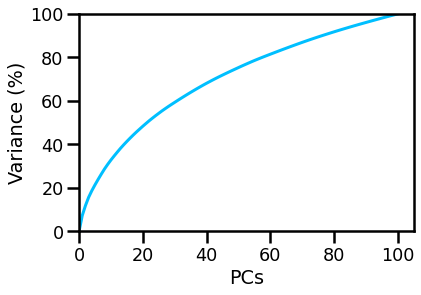

In [0]:
# plot du % de variance expliquée en fonction du nombre de PC
var = modelpca.explainedVariance.cumsum()
sns.set_context(context='poster', font_scale=0.8)
sns.lineplot(x=[i for i in range(n_pc + 1)], y=np.insert(var,0,0)*100, color='deepskyblue')
plt.xlabel('PCs')
plt.ylabel('Variance (%)')
plt.ylim(0,100)
plt.xlim(left=0)
plt.show()

In [0]:
exvar = modelpca.explainedVariance

ipc_cut = 0
threshold = 0.01

for elt in exvar:
    #print(elt)
    if elt < threshold:
        print(elt)
        ipc_cut = np.where(exvar.values == elt)
        break

0.009653678107931104

In [0]:
ipc_cut

Out[37]: (array([28]),)

In [0]:
# sélection des path, label et premieres pc
final = transformed.withColumn("pca", vector_to_array("pca")).select(["path", "label"] + [col("pca")[i] for i in range(ipc_cut[0][0])])

In [0]:
# écriture des fichiers dans le S3
final.write.mode("overwrite").parquet("reduction.parquet")

In [0]:
# conversion dataframe pandas pour visualisation
transformed_pandas = final.toPandas()
transformed_pandas.head()

Out[39]:

,path,label,pca[0],pca[1],pca[2],pca[3],pca[4],pca[5],pca[6],pca[7],pca[8],pca[9],pca[10],pca[11],pca[12],pca[13],pca[14],pca[15],pca[16],pca[17],pca[18],pca[19],pca[20],pca[21],pca[22],pca[23],pca[24],pca[25],pca[26],pca[27]
0,dbfs:/mnt/fruit-360/test-compute/apple_hit_1/r...,apple_hit_1,-4.244428,-1.297873,-19.306000,1.027980,-12.189369,28.808328,33.051261,4.241512,65.718174,-20.346723,-12.926818,12.600773,10.726280,13.537684,-63.182794,17.919787,69.851866,13.306892,4.491259,-21.578765,-4.950536,11.870880,14.009452,-28.178817,28.235327,-4.757267,13.596134,-24.964799
1,dbfs:/mnt/fruit-360/test-compute/apple_hit_1/r...,apple_hit_1,-7.018301,-0.920443,-18.315981,1.381388,-12.419158,26.816941,32.507030,2.377980,62.481883,-16.071861,-12.668102,14.036984,10.910419,12.110568,-55.533819,18.842450,62.320071,9.863960,2.468955,-23.098668,-4.261786,11.004788,14.919112,-26.287162,31.100628,-4.804088,14.505976,-28.283948
2,dbfs:/mnt/fruit-360/test-compute/apple_hit_1/r...,apple_hit_1,-1.693223,-3.599726,-22.868818,-0.686607,-15.410438,26.981728,33.973652,1.065745,69.836426,-18.650492,-16.401048,19.044008,14.997612,14.152865,-64.210602,24.998482,69.357034,9.929316,5.393910,-26.230093,-2.139088,11.916052,18.734644,-33.314726,32.256622,-2.012242,19.683679,-36.692740
3,dbfs:/mnt/fruit-360/test-compute/apple_hit_1/r...,apple_hit_1,-6.182198,-1.590132,-16.349514,1.237405,-11.328907,24.901114,30.628064,4.463446,58.449516,-15.328397,-9.752992,14.119545,5.955996,9.052385,-46.039637,12.803706,55.353541,10.548072,-3.253482,-19.452759,-5.032876,9.753706,12.224153,-23.583799,29.677810,-2.058196,13.138348,-23.052202
4,dbfs:/mnt/fruit-360/test-compute/apple_hit_1/r...,apple_hit_1,-4.675239,-3.264141,-18.014367,3.049207,-16.580817,28.431690,36.584868,11.506236,69.417906,-11.865460,-12.744217,15.198413,8.637235,13.304050,-62.250095,13.321413,73.712128,14.221983,2.847803,-17.779351,-7.483926,12.544003,15.957012,-28.257754,27.994669,0.832953,14.178282,-27.772353


In [0]:
transformed_pandas.shape

Out[41]: (5905, 30)

## Conclusion

Les images de fruits de l'entreprise *Fruits!* ont été compressées (réduction d'un facteur 120) et sont disponibles sur le cloud (espace personnel S3).